# What's Cooking:- Building a Text Classifier
> 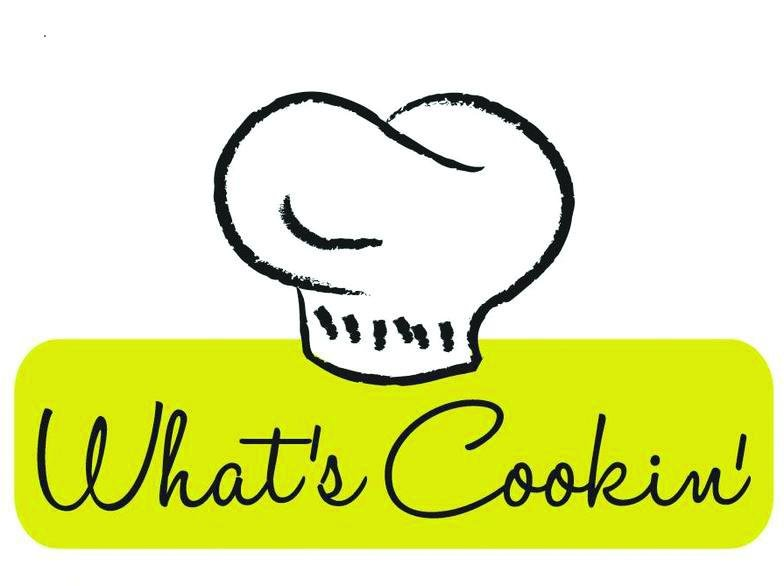

<br>This Kaggle competition asks us to predict the category of a dish's cuisine given a list of its ingredients.<b>This Notebook explores and analyses this dataset to build a Text Classifier</b>. It can also serve as a great starting point for learning how to explore, manipulate, transform and learn from textual data . 
<br><br> This Notebook is divided into the following sections:-
* **A Date with Data**  : As they say, to know someone better you must meet him/her in person. In this section we will go on a date with data to explore and visualize it to gain insights 
* **Experiencing the Change** : As you and data fall in love, data experiences positive changes. In this section data is cleaned and pre-processed (which is a positive change) for model development.
* **Exploring the Unknowns**: As the relationship between you and data goes on, you tend to explore and dig into what suits data the most. In this section we will explore which Feature Engineering technique for representing and converting text data gives the best results.
* **The Final Decision** : Its time to build the Model

<br> Let's Get the Party Started

In [1]:
#Importing all the Libraries needed
#Data Preprocessing
from ipywidgets import interact
import unidecode
import pandas as pd
import random
import json
from collections import Counter
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re
#https://pypi.org/project/tqdm/ information on tqdm
from tqdm import tqdm
tqdm.pandas()

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)
import plotly.offline as offline
import plotly.graph_objs as go
import plotly.express as px

# Data Modeling
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import FastText, Word2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn import model_selection 
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

# Chapter 1 :- A Date with Data  
As the Experts always Say : Always Know your Data
<br>I wouldn't say that knowing your data is the most difficult thing in data science, but it is time-consuming. Therefore, it's easy to overlook this initial step and jump too soon into the water.
So I tried to learn how to swim before jumping into the water

<br>In this section we will go on a date 'Data'. We will explore the data thoroughly , what its like, how it is distributed , what is the target , what affects the targets most ,etc

In [3]:
train = pd.read_json("/kaggle/input/whats-cooking-kernels-only/train.json")
test = pd.read_json("/kaggle/input/whats-cooking-kernels-only/test.json")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
id             39774 non-null int64
cuisine        39774 non-null object
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 2 columns):
id             9944 non-null int64
ingredients    9944 non-null object
dtypes: int64(1), object(1)
memory usage: 155.5+ KB


In [6]:
train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [7]:
train['cuisine'].unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

The test and train data provided in this Kaggle competition are in json format. We have imported the data as a data frame object and the above lines of code show us the initial look of both samples.

### So What can we Expect ?
- There are 39774 unique recipies belonging to different cusines in the train set
- There are 9944 unique recipies in the test set
- Cuisine is the target variable
- The Ingredients for every recipe is given as a list
- Their are recipies from 20 different Cuisines. **This means that the problem at hand is a multi-class classification**

Creating a plot to See the Distribution of Different type of Cuisines in the Train Data

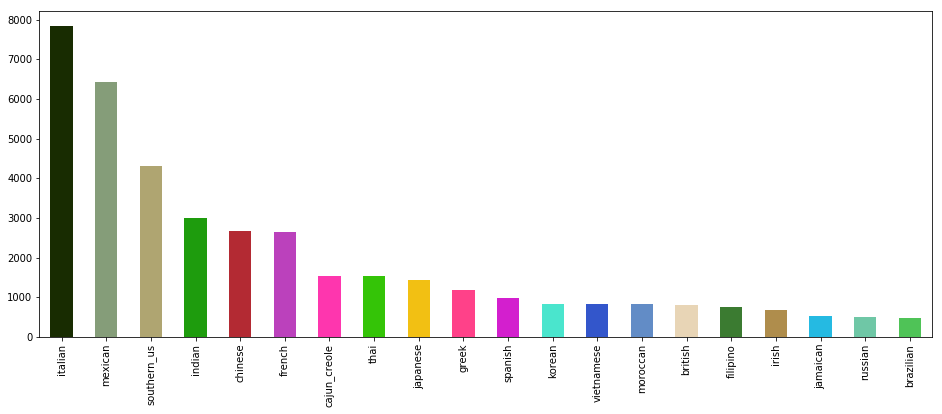

In [8]:
train['cuisine'].value_counts().plot.bar(color=random_colours(20),figsize=(16,6))

From the plot of label distribution, we observe that the most common category in our sample is the Italian cuisine, followed by the Mexican. The least represented cuisines are the Irish, Jamaican, Russian and Brazilian - counting for only 6% of our training sample of recipes.

In [9]:
# Taking Out all the ingredients in the dataset and storing in a list
raw_ingredients = [ing for ingredients in train['ingredients'] for ing in ingredients]

**Time To Look At The Ingredients and their Distribution among different Cuisines**

In [10]:
print('Maximum Number of Ingredients in a Dish: ',train['ingredients'].str.len().max())
print('Minimum Number of Ingredients in a Dish: ',train['ingredients'].str.len().min())

Maximum Number of Ingredients in a Dish:  65
Minimum Number of Ingredients in a Dish:  1


**Creating A Feature that counts the Number Of Ingredients used in a given Recipe**

In [11]:
#no of Ingredients
train['num_ing'] = train['ingredients'].str.len()

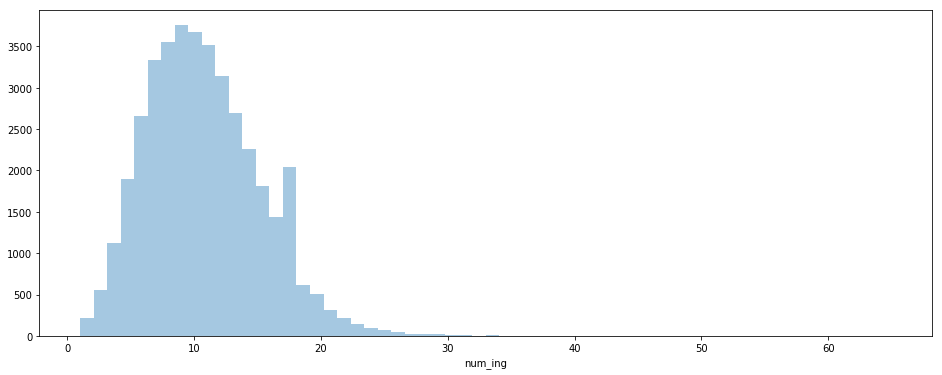

In [12]:
plt.figure(figsize=(16,6))
sns.distplot(train['num_ing'],kde =False ,bins=60)

The distribution of recipe length is right-skewed as we can see from the histogram above.

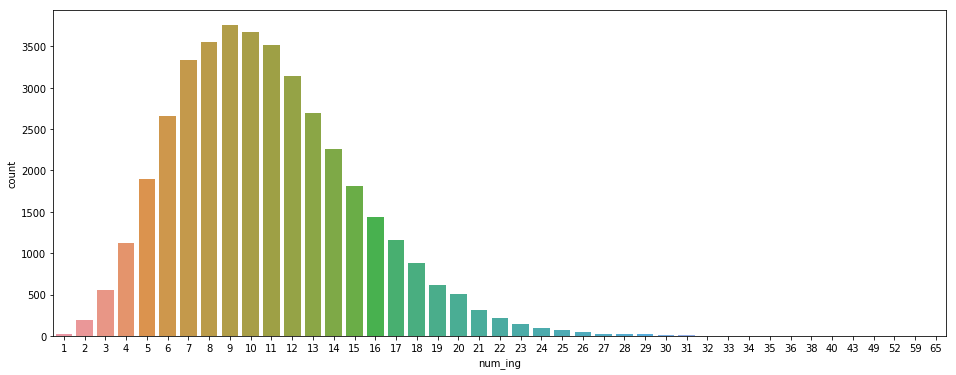

In [13]:
plt.figure(figsize=(16,6))
sns.countplot(x='num_ing',data=train)

We Can See recipes with only one ingredient which is very small and recipes with more than 50 ingredients which is insanely High. These are outliers and could get our model confused , unfortunately there some examples with single ingredient and high ingredients in test set as well

### Let's Take a closer look at the extremes

In [14]:
longrecip = train[train['num_ing'] > 30]
print(len(longrecip))

40


It seems that 40 recipes consist of more than 30 ingredients!


In [15]:
longrecip['cuisine'].value_counts()

mexican         12
indian           5
italian          3
thai             3
southern_us      2
jamaican         2
cajun_creole     2
brazilian        2
chinese          2
moroccan         2
filipino         1
japanese         1
spanish          1
french           1
vietnamese       1
Name: cuisine, dtype: int64

**Explore the ingredients in the longest recipe in our training set**

In [16]:
print(longrecip[longrecip['num_ing'] == 65]['ingredients'].values)
print('Cuisine :-',longrecip[longrecip['num_ing'] == 65]['cuisine'].values)

[list(['fettucine', 'fresh marjoram', 'minced garlic', 'olive oil', 'garlic powder', 'large eggs', 'Alfredo sauce', 'vegetable oil', 'cajun seasoning', 'shredded romano cheese', 'basil dried leaves', 'salt', 'cayenne pepper', 'scallions', 'red bell pepper', 'boneless skinless chicken breast halves', 'soba', 'pasta sauce', 'kosher salt', 'milk', 'fresh ginger', 'ground black pepper', 'flour', 'cooked chicken', 'coarse salt', 'lemon', 'diced tomatoes', 'garlic', 'rice vinegar', 'Neufchâtel', 'garlic cloves', 'dried parsley', 'frozen artichoke hearts', 'penne', 'pepper', 'sweet onion', 'part-skim mozzarella cheese', 'parmigiano reggiano cheese', 'basil leaves', 'onion powder', 'red wine vinegar', 'red pepper flakes', 'orzo', 'crushed red pepper', 'all-purpose flour', 'freshly ground pepper', 'sliced mushrooms', 'panko breadcrumbs', 'plum tomatoes', 'fresh basil', 'fresh leav spinach', 'water', 'sun-dried tomatoes', 'ground pepper', 'grated parmesan cheese', 'boneless skinless chicken brea

The longest recipe in our sample is part of the Italian cuisine. However, Italian cuisine is often associated with simple recipes. Also 65 ingredients can be considered too many for any recipe.So, My guess is that the case is more about wrong data in our sample rather than anything else

In [17]:
shortrecip = train[train['num_ing']<=2]
print(len(shortrecip))

215


**It seems that 215 recipes consist of less than or equal to 2 ingredients**

In [18]:
shortrecip['cuisine'].value_counts()

italian         37
french          34
southern_us     23
mexican         22
indian          19
japanese        16
vietnamese      11
chinese         10
spanish          8
cajun_creole     7
korean           5
greek            4
thai             4
irish            3
british          3
filipino         3
brazilian        3
russian          1
jamaican         1
moroccan         1
Name: cuisine, dtype: int64

In [19]:
train[train['num_ing'] <= 1]

,id,cuisine,ingredients,num_ing
940,4734,japanese,[sushi rice],1
2088,7833,vietnamese,[dried rice noodles],1
6787,36818,indian,[plain low-fat yogurt],1
7011,19772,indian,[unsalted butter],1
8181,16116,japanese,[udon],1
8852,29738,thai,[sticky rice],1
8990,41124,indian,[butter],1
10506,32631,mexican,[corn tortillas],1
13178,29570,thai,[grained],1
17804,29849,southern_us,[lemonade concentrate],1


But, are all ingredients valid? For example, do ingredients consisting of less than 2 characters make sense?

In [20]:
[ingredient for ingredient in raw_ingredients if len(ingredient) <= 2]

['mi', 'mi', 'v8', 'v8']

Apparently Not all the Words make sense , We will keep this in mind

Explore recipe length distribution in each cuisine 

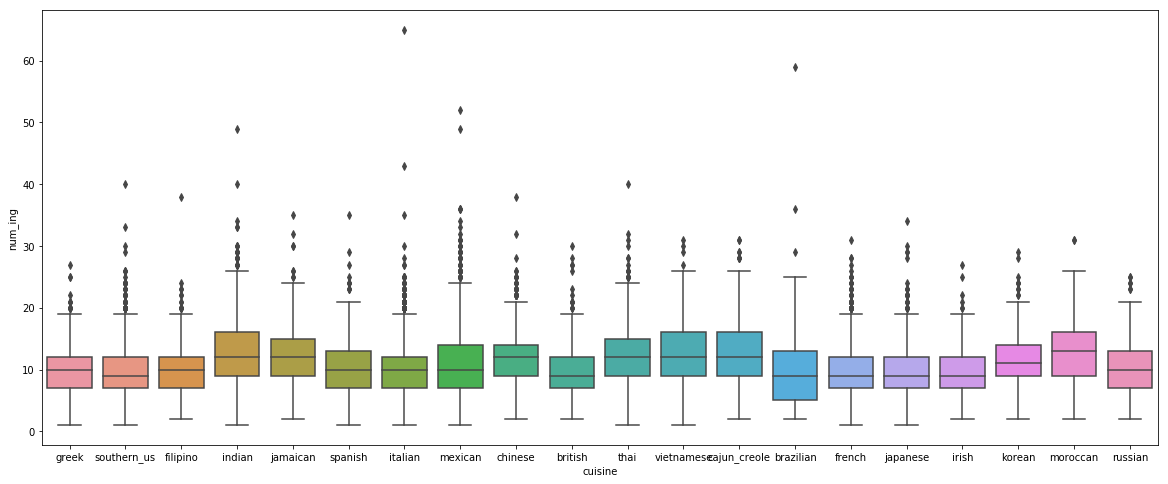

In [21]:
plt.figure(figsize=(20,8))
sns.boxplot(x='cuisine',y='num_ing',data=train)

From the box plots of recipe length distributions, we can make several observations:

- The Moroccan cuisine seems to have the longest recipes on average compared to all the rest cuisines in our sample
- We observe the opposite phenomenon for the Irish, British, French and Southern_us cuisine
- There exist outliers in all cuisines
- Recipes part of the European cuisine tend to be with average length or shorter compared to the rest of the sample.


### Special Characters

In [22]:
' '.join(sorted([char for char in set(' '.join(raw_ingredients)) if re.findall('[^A-Za-z]', char)]))

"  ! % & ' ( ) , - . / 0 1 2 3 4 5 6 7 8 9 ® â ç è é í î ú ’ € ™"

The Special Characters have come from ingredients from a specific company or from ingredients which come in packaging:
- "Bertolli® Alfredo Sauce"
- "Progresso™ Chicken Broth"
- "green bell pepper, slice"
- "half & half"
- "asafetida (powder)"
- "Spring! Water"

### Upper Cases
Since Company names and Region Names are used in ingredients it may have been written in uppercase so checking for that

In [23]:
list(set([ingredient for ingredient in raw_ingredients if re.findall('[A-Z]+', ingredient)]))[:5]

['Meyer lemon peel',
 'Progresso Diced Tomatoes',
 'Alaskan king crab legs',
 'Argo Corn Starch',
 'Praline Liqueur']

 ### Apostrophes

In [24]:
list(set([ingredient for ingredient in raw_ingredients if '’' in ingredient]))

['Breakstone’s Sour Cream', 'sheep’s milk cheese', 'Zatarain’s Jambalaya Mix']

### Hyphens ( - )
We will Replace (-)  with null string ("") later on if found

In [25]:
list(set([ingredient for ingredient in raw_ingredients if re.findall('-', ingredient)]))[:5]

['low-fat cream cheese',
 'low-sodium fat-free chicken broth',
 'Jell-O Gelatin',
 'bone-in ribeye steak',
 'Ro-Tel Diced Tomatoes & Green Chilies']

### Numbers

In [26]:
temp_ing = list(set([ingredient for ingredient in raw_ingredients if re.findall('[0-9]', ingredient)]))
temp_ing[:6]

['(15 oz.) refried beans',
 '1% low-fat cottage cheese',
 '2% reduced-fat milk',
 '95% lean ground beef',
 '(14.5 oz.) diced tomatoes',
 '8 ounc ziti pasta, cook and drain']

In [27]:
len(temp_ing)

40

**Numbers show quantity or density. Quantities can be a factor of identifying the cuisine , but the number of ingredients containing numbers is just 40 so it will be better to remove the numbers**

### Units

In [28]:
units = ['inch', 'oz', 'lb', 'ounc', '%'] # ounc is a misspelling of ounce?

@interact(unit=units)
def f(unit):
    ingredients_df = pd.DataFrame([ingredient for ingredient in raw_ingredients if unit in ingredient], columns=['ingredient'])
    return ingredients_df.groupby(['ingredient']).size().reset_index(name='count').sort_values(['count'], ascending=False)

,ingredient,count
0,kinchay,3
1,"pork chops, 1 inch thick",2


We will remove all the units from the ingredients as it will not be helpful for the model 

### Regions
We will explore whether or not the name of the region is present in the name of ingredients , For Eg:- Greek Yogurt. If found this will help the model and an unigram model will perform better

In [29]:
keywords = ['american', 'greek', 'filipino', 'indian', 'jamaican', 'spanish', 'italian', 'mexican', 'chinese', 'thai',
    'vietnamese', 'cajun', 'creole', 'french', 'japanese', 'irish', 'korean', 'moroccan', 'russian',
]
d ={}
for k in keywords:
    temp = [ingredient for ingredient in raw_ingredients if k in ingredient]
    d[k] = temp

In [30]:
d['american']

['american cheese slices',
 'american cheese slices',
 'american cheese slices',
 'american cheese food']

So we can see there are region names present , we will keep this in our mind

### Exploring Most Common Ingredients in the whole dataset
We make use of counter function from the collections module here . Help on this function can be found from here :
https://www.youtube.com/watch?v=cDw3ppRKAck 

In [31]:
top = Counter([item for sublist in train['ingredients'] for item in sublist])
print(top.most_common(20))

[('salt', 18049), ('onions', 7972), ('olive oil', 7972), ('water', 7457), ('garlic', 7380), ('sugar', 6434), ('garlic cloves', 6237), ('butter', 4848), ('ground black pepper', 4785), ('all-purpose flour', 4632), ('pepper', 4438), ('vegetable oil', 4385), ('eggs', 3388), ('soy sauce', 3296), ('kosher salt', 3113), ('green onions', 3078), ('tomatoes', 3058), ('large eggs', 2948), ('carrots', 2814), ('unsalted butter', 2782)]


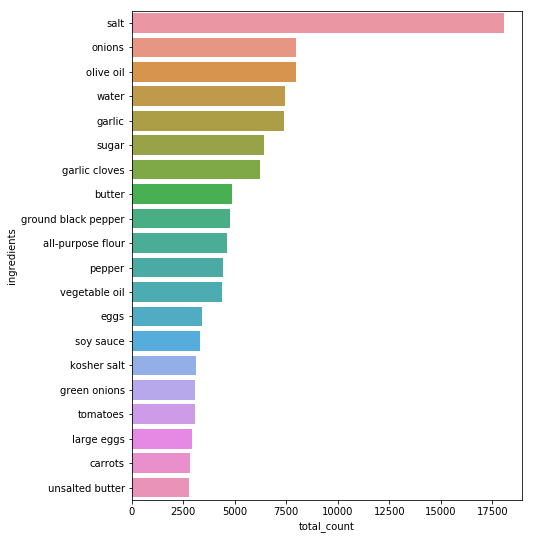

In [32]:
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['ingredients','total_count']
plt.figure(figsize=(7,9))
sns.barplot(x='total_count',y='ingredients',data=temp)

It seems that salt is the most commonly used ingredient which is not surprising at all! We also find water, onions, garlic and olive oil - not so surprising also .
**Salt is such a common ingredient that we expect it to have poor predictive power in recognizing the type of cuisine**
We will remove salt and some other common ingredients from the mix to make our model do better

### Exploring how many different ingredients can be found in each 

In [33]:
labels = ['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian']
templist=[]
for cus in labels:
    lisofing=[]
    for lis in train[train['cuisine'] == cus]['ingredients']:
        for ing in lis:
            lisofing.append(ing)
    templist.append([cus,len(list(set(lisofing)))])
Unique_ing = pd.DataFrame(templist,columns=['cuisine','unique_ing']).sort_values(by='unique_ing',ascending=False)

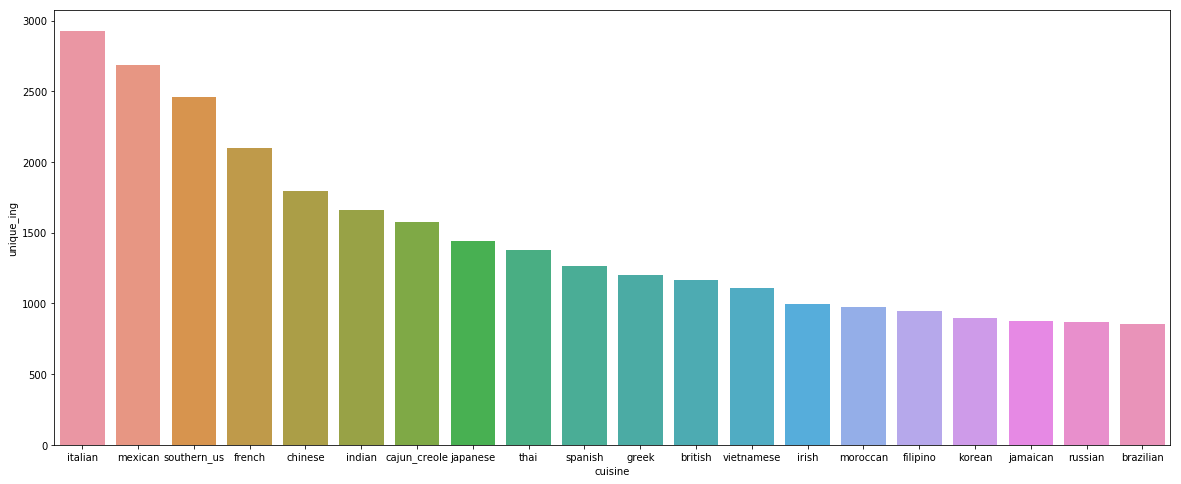

In [34]:
plt.figure(figsize=(20,8))
sns.barplot(x='cuisine',y='unique_ing',data=Unique_ing)

From the above bar chart, we can see that it is not necessary that cuisines with more instances in the training sample should be associated with more ingredients representing them. It turns out that the French cuisine which is 6,65% of the training sample has more variability in ingredients than the Indian cuisine (this observation is unexpected since Indians use many spices in their recipes

In [35]:
def cuisine_unique(cuisine,numingr,raw_ingredients):
    '''
    Input:
        cuisine - cuisine category (ex. 'brazilian');
        numingr - how many specific ingredients do you want to see in the final result; 
        allingredients - list  for item in train_data[train_data.cuisine == cuisine]['ingredients']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.cuisine != cuisine]['ingredients']:
        for ingr in item:
            allother .append(ingr)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_ingredients if x not in allother]
    
    mycounter = Counter()
     
    for item in train[train.cuisine == cuisine]['ingredients']:
        for ingr in item:
            mycounter[ingr] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    cuisinespec = pd.DataFrame(mycounter.most_common(numingr), columns = ['ingredient','count'])
    
    return cuisinespec

In [36]:
cuisinespec= cuisine_unique('mexican', 10, raw_ingredients)
print("The top 10 unique ingredients in Mexican cuisine are:")
cuisinespec

The top 10 unique ingredients in Mexican cuisine are:


,ingredient,count
0,refried beans,250
1,taco seasoning mix,181
2,red enchilada sauce,65
3,taco sauce,63
4,poblano chilies,33
5,mexican chocolate,32
6,baked tortilla chips,31
7,green enchilada sauce,31
8,Mexican beer,30
9,chipotle,25


# Chapter 2 :- Experiencing the Change

In this section we will :-
* Remove outliers
* convert to lowercase
* remove hyphen
* remove numbers
* remove words which consist of less than 2 characters
* remove units
* remove accents
* lemmatize

In [37]:
#Removing Outliers Values that were irrevelant to model
train = train[train['num_ing'] > 1]

In [38]:
train = train[train['num_ing']<60]

In [39]:
train.shape

(39751, 4)

In [40]:
lemmatizer = WordNetLemmatizer()
def preprocess(ingredients):
    ingredients_text = ' '.join(ingredients)
    ingredients_text = ingredients_text.lower() #Lower - Casing
    ingredients_text = ingredients_text.replace('-', ' ') # Removing Hyphen
    
    #Wrong name
    ingredients_text = ingredients_text.replace('wasabe', 'wasabi')
    ingredients_text = ingredients_text.replace('fish sauce', 'fishsauce')
    ingredients_text = ingredients_text.replace('coconut cream', 'coconutcream')
    ingredients_text = ingredients_text.replace('yellow onion', 'yellowonion')
    ingredients_text = ingredients_text.replace('cream cheese', 'creamcheese') 
    ingredients_text = ingredients_text.replace('baby spinach', 'babyspinach')
    ingredients_text = ingredients_text.replace('coriander seeds', 'corianderseeds')
    ingredients_text = ingredients_text.replace('corn tortillas', 'corntortillas')
    ingredients_text = ingredients_text.replace('rice cakes', 'ricecakes')
    
    words = []
    for word in ingredients_text.split():
        word = re.sub("[0-9]"," ",word) #removing numbers,punctuations and special characters
        word = re.sub((r'\b(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\b'), ' ', word) # Removing Units
        if len(word) <= 2: continue # Removing words with less than two characters
        word = unidecode.unidecode(word) #Removing accents
        word = lemmatizer.lemmatize(word) #Lemmatize
        if len(word) > 0: words.append(word)
    return ' '.join(words)

https://pypi.org/project/Unidecode/
Information about unidecode can be read from here

In [41]:
#Checking if our function works
for ingredient, expected in [
    ('Eggs', 'egg'),
    ('all-purpose flour', 'all purpose flour'),
    ('purée', 'puree'),
    ('1% low-fat milk', 'low fat milk'),
    ('half & half', 'half half'),
    ('safetida (powder)', 'safetida (powder)')
]:
    actual = preprocess([ingredient])
    assert actual == expected, f'"{expected}" is excpected but got "{actual}"'

In [42]:
train['x'] = train['ingredients'].progress_apply(preprocess)
test['x'] = test['ingredients'].progress_apply(preprocess)
train.head()

100%|██████████| 9944/9944 [00:02<00:00, 3557.04it/s]


,id,cuisine,ingredients,num_ing,x
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,romaine lettuce black olive grape tomato garli...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,plain flour ground pepper salt tomato ground b...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,egg pepper salt mayonaise cooking oil green ch...
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,water vegetable oil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,black pepper shallot cornflour cayenne pepper ...


Now That we have completed cleaning and changed our data for the better its time to chose the method which we will use to tranform text into numbers

# Chapter :- Exploring the Unknowns

We need to convert ingredeints to numeric values so that computers can do mathematical operations. My question was what the best representation is for this dataset.

I have compared representations below.

* CountVectorizer
* TfidfVectorizer
* TfidfVectorizer + SVD
* Word2Vec
* fastText

In [43]:
def apply_word2vec(sentences):
    vectorizer = Word2Vec(
        sentences,
        size=500,
        window=20,
        min_count=3,
        sg=1,
        iter=20
    )

    def to_vector(sentence):
        words = [word for word in sentence if word in vectorizer.wv.vocab]
        if words:
            return np.mean(vectorizer[words], axis=0)
        else:
            return np.zeros(500)

    return np.array([to_vector(sentence) for sentence in sentences])

def apply_fasttext(sentences):
    vectorizer = FastText(
        size=500,
        window=20,
        min_count=3,
        sg=1,
        iter=20
        )
    vectorizer.build_vocab(sentences)
    vectorizer.train(sentences, total_examples=vectorizer.corpus_count, epochs=vectorizer.iter)

    def to_vector(sentence):
        words = [word for word in sentence if word in vectorizer.wv.vocab]
        if words:
            return np.mean(vectorizer.wv[words], axis=0)
        else:
            return np.zeros(500)

    return np.array([to_vector(sentence) for sentence in sentences])

def train_model(x, y, n_splits=3):
    model = LogisticRegression(C=10, solver='sag', multi_class='multinomial', max_iter=300, n_jobs=-1)
    i = 0
    accuracies = []
    kfold = KFold(n_splits)
    for train_index, test_index in kfold.split(x):
        classifier = LogisticRegression(C=10, solver='sag', multi_class='multinomial', max_iter=300, n_jobs=-1)
        classifier.fit(x[train_index], y[train_index])
        predictions = classifier.predict(x[test_index])
        accuracies.append(accuracy_score(predictions, y[test_index]))
        i += 1
    average_accuracy = sum(accuracies) / len(accuracies)
    return average_accuracy

def run_experiment(preprocessor):
    train = json.load(open('/kaggle/input/whats-cooking-kernels-only/train.json'))

    target = [doc['cuisine'] for doc in train]
    lb = LabelEncoder()
    y = lb.fit_transform(target)

    x = preprocessor.fit_transform(train)

    return train_model(x, y)


In [44]:
import time
results = []
for (name, preprocessor) in [
    ('TfidfVectorizer()', make_pipeline(
        FunctionTransformer(lambda x: [" ".join(doc['ingredients']).lower() for doc in x], validate=False),
        TfidfVectorizer(),
    )),
    ('TfidfVectorizer(binary=True)', make_pipeline(
        FunctionTransformer(lambda x: [" ".join(doc['ingredients']).lower() for doc in x], validate=False),
        TfidfVectorizer(binary=True),
    )),
    ('TfidfVectorizer(min_df=3)', make_pipeline(
        FunctionTransformer(lambda x: [" ".join(doc['ingredients']).lower() for doc in x], validate=False),
        TfidfVectorizer(min_df=3),
    )),
    ('TfidfVectorizer(min_df=5)', make_pipeline(
        FunctionTransformer(lambda x: [" ".join(doc['ingredients']).lower() for doc in x], validate=False),
        TfidfVectorizer(min_df=5),
    )),
    ('TfidfVectorizer(max_df=0.95)', make_pipeline(
        FunctionTransformer(lambda x: [" ".join(doc['ingredients']).lower() for doc in x], validate=False),
        TfidfVectorizer(max_df=0.95),
    )),
     ('TfidfVectorizer(max_df=0.9)', make_pipeline(
        FunctionTransformer(lambda x: [" ".join(doc['ingredients']).lower() for doc in x], validate=False),
        TfidfVectorizer(max_df=0.9),
    )),
    ('TfidfVectorizer(sublinear_tf=True)', make_pipeline(
        FunctionTransformer(lambda x: [" ".join(doc['ingredients']).lower() for doc in x], validate=False),
        TfidfVectorizer(sublinear_tf=True),
    )),
    ('TfidfVectorizer(strip_accents=unicode)', make_pipeline(
        FunctionTransformer(lambda x: [" ".join(doc['ingredients']).lower() for doc in x], validate=False),
        TfidfVectorizer(strip_accents='unicode'),
    )),
]:
    start = time.time()
    accuracy = run_experiment(preprocessor)
    execution_time = time.time() - start
    results.append({
        'name': name,
        'accuracy': accuracy,
        'execution time': f'{round(execution_time, 2)}s'
    })
pd.DataFrame(results, columns=['name', 'accuracy', 'execution time']).sort_values(by='accuracy', ascending=False)

,name,accuracy,execution time
6,TfidfVectorizer(sublinear_tf=True),0.782572,14.02s
0,TfidfVectorizer(),0.782471,14.32s
4,TfidfVectorizer(max_df=0.95),0.782471,14.36s
5,TfidfVectorizer(max_df=0.9),0.782471,14.38s
2,TfidfVectorizer(min_df=3),0.782370,14.39s
7,TfidfVectorizer(strip_accents=unicode),0.782370,13.93s
1,TfidfVectorizer(binary=True),0.781918,14.5s
3,TfidfVectorizer(min_df=5),0.781038,14.2s


So, We can see Tf-Idf is the Method suitable for our Data

# Chapter 4:- The Final Decision

It's Time to build the model , first I will convert text data into numerical data using tfidf and then use SVC to build a model

In [45]:
vectorizer = TfidfVectorizer(sublinear_tf=True)

In [46]:
X_train = vectorizer.fit_transform(train['x'].values)
X_train.sort_indices()
X_test = vectorizer.transform(test['x'].values)

In [47]:
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(train['cuisine'].values)

I tried LogisticRegression, GaussianProcessClassifier, GradientBoostingClassifier, MLPClassifier, LGBMClassifier, SGDClassifier, Keras but SVC was working the best,So I choose SVC to build our final model

In [48]:
classifier = SVC(C=100, # penalty parameter
	 			 kernel='rbf', # kernel type, rbf working fine here
	 			 degree=3, # default value
	 			 gamma=1, # kernel coefficient
	 			 coef0=1, # change to 1 from default value of 0.0
	 			 shrinking=True, # using shrinking heuristics
	 			 tol=0.001, # stopping criterion tolerance 
	      		 probability=False, # no need to enable probability estimates
	      		 cache_size=200, # 200 MB cache size
	      		 class_weight=None, # all classes are treated equally 
	      		 verbose=False, # print the logs 
	      		 max_iter=-1, # no limit, let it run
          		 decision_function_shape=None, # will use one vs rest explicitly 
          		 random_state=None)

In [49]:
%%time
model = OneVsRestClassifier(classifier, n_jobs=4)
model.fit(X_train, Y_train)

CPU times: user 410 ms, sys: 296 ms, total: 706 ms
Wall time: 28min 9s


OneVsRestClassifier(estimator=SVC(C=100, cache_size=200, class_weight=None,
                                  coef0=1, decision_function_shape=None,
                                  degree=3, gamma=1, kernel='rbf', max_iter=-1,
                                  probability=False, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=4)

In [50]:
print ("Predict on test data ... ")
Y_test = model.predict(X_test)
Y_pred = label_encoder.inverse_transform(Y_test)

Predict on test data ... 


In [51]:
Y_pred[:20]

array(['irish', 'southern_us', 'italian', 'cajun_creole', 'italian',
       'southern_us', 'greek', 'chinese', 'mexican', 'british', 'italian',
       'greek', 'indian', 'italian', 'british', 'french', 'mexican',
       'southern_us', 'mexican', 'southern_us'], dtype=object)

In [52]:
test_id = test['id']
sub = pd.DataFrame({'id': test_id, 'cuisine': Y_pred}, columns=['id', 'cuisine'])
sub.to_csv('submission.csv', index=False)

In [53]:
sub.head()

,id,cuisine
0,18009,irish
1,28583,southern_us
2,41580,italian
3,29752,cajun_creole
4,35687,italian


This is My first kernel on kaggle. I have learnt a lot from this competition ,from the kaggle community and some exceptionally well written kernels.
<br>The kernel By Rejasupotaro https://www.kaggle.com/rejasupotaro/representations-for-ingredients , helped me a lot and taught me how to compare all the Feature Engineering Techniques and choose the best one.
<br>I wrote this kernel so that anyone starting with machine learning and natural language processing can understand it.
### If you find my kernel useful and like it, please don't forget to upvote. Thank you!

# Ressources

- https://www.kaggle.com/code/tanulsingh077/what-s-cooking
- https://www.kaggle.com/code/souvikb07/what-s-cooking